In [2]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as math

from glob import glob
from collections import OrderedDict
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

In [3]:
# Datos proporcionados
data = """
2.00000E-02	3.379E+01	2.788E+01
3.00000E-02	1.092E+01	9.349E+00
4.00000E-02	4.862E+00	4.163E+00
5.00000E-02	2.613E+00	2.192E+00
6.00000E-02	1.593E+00	1.290E+00
8.00000E-02	7.630E-01	5.581E-01
1.00000E-01	4.584E-01	2.949E-01
1.50000E-01	2.217E-01	1.027E-01
2.00000E-01	1.559E-01	5.781E-02
3.00000E-01	1.119E-01	3.617E-02
4.00000E-01	9.413E-02	3.121E-02
5.00000E-01	8.362E-02	2.933E-02
6.00000E-01	7.625E-02	2.826E-02
8.00000E-01	6.605E-02	2.681E-02
1.00000E+00	5.901E-02	2.562E-02
1.25000E+00	5.261E-02	2.428E-02
1.50000E+00	4.803E-02	2.316E-02
"""

# Dividir los datos en cada columna
columna1 = []
columna2 = []
columna3 = []

for linea in data.split('\n'):
    if linea.strip() != '':
        valores = linea.split()
        columna1.append(float(valores[0]))
        columna2.append(float(valores[1]))
        columna3.append(float(valores[2]))

# Crear arrays numpy para cada columna
E_biblio = np.array(columna1)*1e3
mu_biblio = np.array(columna2)*8.96/10

In [4]:
def compton(x, b):

    tau= b*((((1+x/511)/(x/511)**2)*((2*(1+x/511)/(1+2*x/511))-np.log(1+2*x/511)/x/511)))+np.log(1+2*x/511)/(2*x/511)-(1+3*x/511)/(1+2*x/511)**2

    return tau

def photo(x, a):

    sigma=(a)*29**5/((x/511)**(3.5))

    return sigma

In [5]:
def FC(x,a,b):
  FC= (a)*29**5/((x/511)**(3.5)) + b*((((1+x/511)/(x/511)**2)*((2*(1+x/511)/(1+2*x/511))-np.log(1+2*x/511)/x/511)))+np.log(1+2*x/511)/(2*x/511)-(1+3*x/511)/(1+2*x/511)**2
  return(FC)

Energias_mu_Int_new=np.array([ 31, 59.6, 81, 511, 662, 1173, 1332])
Mu_L_Int_new=np.array([6.72582525, 1.32625374, 0.32710877, 0.16165694, 0.05183674,0.01719689, 0.0434188 ])
Mus_seba=np.array([5.37056086,1.21477457,0.3598539,0.16165694,0.05076173,0.02657659,0.04901802])
err_mu_seba=np.array([0.24581814, 0.06168981, 0.02291373, 0.01723596, 0.00178476,0.0008863 , 0.00326068])

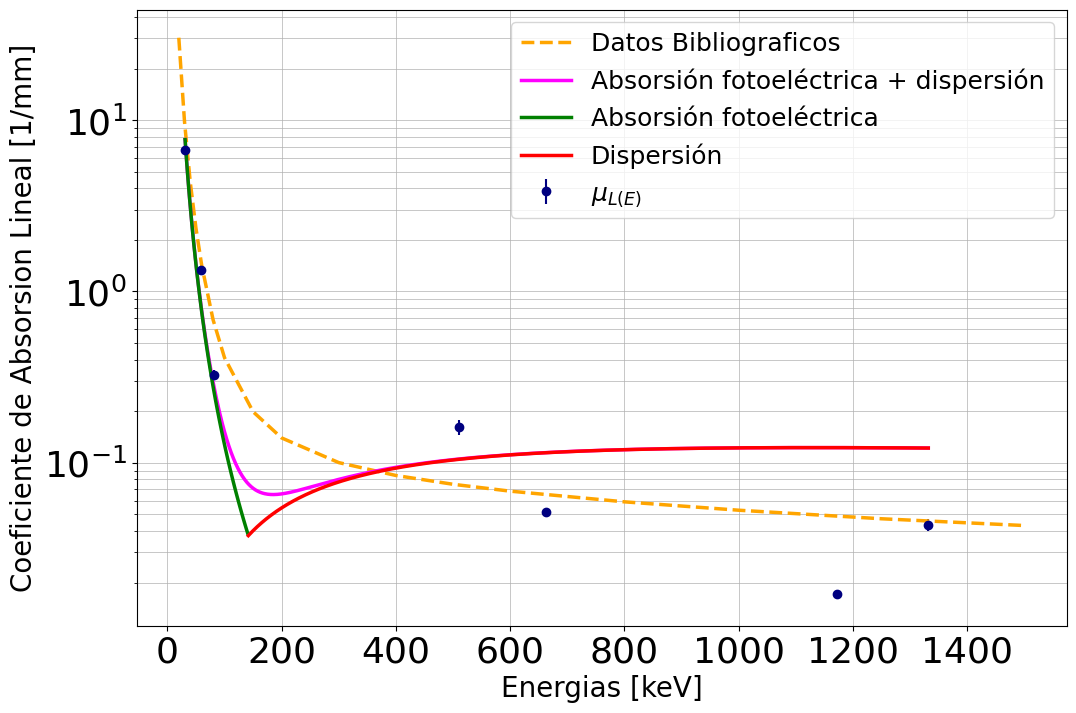

In [13]:
popt_FC,cov_FC = curve_fit(FC, Energias_mu_Int_new, Mu_L_Int_new, sigma= err_mu_seba, bounds=([0, 0], [np.inf, np.inf]))
perr_FC = np.sqrt(np.diag(cov_FC))

Continuo=np.linspace(Energias_mu_Int_new[0], Energias_mu_Int_new[len(Energias_mu_Int_new)-1], 1000)

plt.figure(figsize=(12,8))

plt.errorbar(Energias_mu_Int_new, Mu_L_Int_new, yerr=err_mu_seba, fmt='o', color='navy', label=r'$\mu_{L(E)}$')
plt.semilogy(E_biblio, mu_biblio, color='orange', linestyle='dashed', label='Datos Bibliograficos', linewidth=2.5)
plt.semilogy(Continuo, FC(Continuo, *popt_FC), color='magenta', label='Absorsión fotoeléctrica + dispersión', linewidth=2.5)
plt.semilogy(Continuo[0:85], photo(Continuo[0:85], popt_FC[0]), color='green', label='Absorsión fotoeléctrica', linewidth=2.5)
plt.semilogy(Continuo[85:], compton(Continuo[85:], popt_FC[1]), color='red', label='Dispersión', linewidth=2.5)
plt.grid(linewidth=0.5, which='both')
plt.xlabel('Energias [keV]', fontsize=20)
plt.ylabel('Coeficiente de Absorsion Lineal [1/mm]', fontsize=20)
plt.legend(fontsize=18)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

plt.savefig('Efectos.jpg', format='jpg', dpi=1000, bbox_inches='tight')